In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import pickle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
# from yellowbrick.target import ClassBalance
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [347]:
# Load the data and create a copy to use to verify preprocessing steps
quicken_df = pd.read_csv('data/bank_of_america.csv')
check_df = quicken_df.copy()
# Pull Census Tract dictionary from different notebook
%store -r FIPS_dict

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [348]:
# Initialize dictionary to store bank information
boa_dict_keys = ['Lender', 'Likelihood of Approval', 'Certainty of Prediction', 'Approval Threshold', 'Black applicant error rate', 
                                         'Asian applicant error rate', 'Hispanic applicant error rate', 
                                         'Female applicant error rate']
boa_dict={}
boa_dict['Lender'] = 'Bank of America'

# Step 1: Drop Perfect Predictors, Census added columns, irrelevant columns

In [349]:
confirmed_perfect_pred = ['denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'purchaser_type', 'preapproval', 
                       'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'origination_charges', 
                       'discount_points', 'lender_credits', 'initially_payable_to_institution', 'denial_reason-4',
                        'total_points_and_fees']
quicken_df = quicken_df.drop(confirmed_perfect_pred, axis=1)

In [350]:
census_appended = ['tract_minority_population_percent', 'tract_population', 'ffiec_msa_md_median_family_income',
                  'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
                  'tract_median_age_of_housing_units']
quicken_df = quicken_df.drop(census_appended, axis=1)

In [351]:
drop_irrelevant = ['state_code', 'county_code', 'open-end_line_of_credit', 'manufactured_home_land_property_interest', 
                  'manufactured_home_secured_property_type', 'co-applicant_credit_score_type', 'applicant_ethnicity-2',
                  'applicant_ethnicity-3', 'applicant_ethnicity-4', 'co-applicant_ethnicity-1', 'co-applicant_ethnicity-2',
                  'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity_observed',
                  'applicant_race-2', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 
                  'co-applicant_race-1', 'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4', 
                  'co-applicant_race-5', 'co-applicant_race_observed', 'co-applicant_sex', 'applicant_sex_observed',
                  'co-applicant_sex_observed', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62',
                  'submission_of_application', 'derived_loan_product_type', 'interest_only_payment', 'applicant_ethnicity-1',
                  'applicant_race-1', 'applicant_sex', 'derived_msa-md', 'applicant_ethnicity-5', 
                  'co-applicant_ethnicity-5', 'activity_year', 'lei', 'multifamily_affordable_units', 
                  'aus-2', 'aus-3', 'aus-4', 'aus-5']
quicken_df = quicken_df.drop(drop_irrelevant, axis=1)

In [352]:
# drop features that would be difficult or impossible to gather from user input
drop_impossible = ['negative_amortization', 'balloon_payment', 'applicant_ethnicity_observed', 
                   'applicant_race_observed', 'aus-1', 'other_nonamortizing_features', 'applicant_credit_score_type',
                  'intro_rate_period']
quicken_df = quicken_df.drop(drop_impossible, axis=1)

# Step 2: Condense High Cardinality Columns

In [353]:
# action taken
quicken_df = quicken_df[~quicken_df['action_taken'].isin([4,5,7,8])]
quicken_df['action_taken'] = quicken_df['action_taken'].map(lambda x: 0 if x ==3 else 1)

# Step 3: Select loans that meet the following criteria, then drop those variables
* Loan Purpose: Home purchase (no refi, home improvement, etc)
* Lien Status: 1st liens only
* Reverse Mortgage: exclude
* Business/commercial: exclude
* Only principal, single family homes

In [354]:
quicken_df = quicken_df[quicken_df['loan_purpose'] == 1]
quicken_df = quicken_df[quicken_df['lien_status'] == 1]
quicken_df = quicken_df[quicken_df['reverse_mortgage'] == 2]
quicken_df = quicken_df[quicken_df['business_or_commercial_purpose'] == 2]
quicken_df = quicken_df[(quicken_df['total_units'] == '1') | (quicken_df['total_units'] == 1)]
quicken_df = quicken_df[quicken_df['occupancy_type'] == 1]

In [355]:
drop_after_subselection = ['loan_purpose', 'lien_status', 'reverse_mortgage', 'business_or_commercial_purpose', 
                          'total_units', 'occupancy_type']
quicken_df = quicken_df.drop(drop_after_subselection, axis=1)

# Step 4: Ensure all null values are coded the same way, or drop if very few nulls
* Applicant credit score type mostly null (9)

In [356]:
quicken_df = quicken_df[quicken_df['conforming_loan_limit'] != 'U']
# quicken_df['applicant_credit_score_type'] = quicken_df['applicant_credit_score_type'].apply(lambda x: np.nan if x == 9 else x)
# quicken_df['applicant_ethnicity_observed'] = quicken_df['applicant_ethnicity_observed'].apply(lambda x: np.nan if x == 3 else x)
# quicken_df['applicant_race_observed'] = quicken_df['applicant_race_observed'].apply(lambda x: np.nan if x == 3 else x)

In [357]:
age_na_lst = [8888, '8888', '9999', 9999]
quicken_df['applicant_age'] = quicken_df['applicant_age'].apply(lambda x: np.nan if x in age_na_lst else x)

# Step 5: Variable Encoding
* Dropped nan before encoding, or ignored
* DIR
* Age (dropped 908 nan)
* Census Tract

In [358]:
DIR_mapper = {'20%-<30%': 25, '30%-<36%': 33, '>60%': 65, '<20%': 15, '50%-60%': 55}


quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'] \
                                    .map(lambda x: DIR_mapper[x] if x in DIR_mapper else int(x), na_action='ignore')

In [359]:
quicken_df = quicken_df[quicken_df['applicant_age'].notnull()]

In [360]:
# Create ordinalencoder object
enc = OrdinalEncoder()

# Convert column to array
age_df = quicken_df[['applicant_age']].to_numpy()
enc.fit(age_df)
enc.categories_

# fitted encoder to array
enc_age_arr = enc.transform(quicken_df[['applicant_age']].to_numpy())

# Apply encoder transformation
quicken_df['applicant_age'] = enc_age_arr

In [407]:
quicken_df['loan_type'].value_counts()

1    52412
2     3658
3      463
Name: loan_type, dtype: int64

In [361]:
quicken_df = quicken_df.dropna(subset=['census_tract'])
quicken_df['census_tract'] = quicken_df['census_tract'].astype(int)
quicken_df['census_tract'] = quicken_df['census_tract'].astype(str)
quicken_df['census_tract'] = quicken_df['census_tract'].map(FIPS_dict)

In [395]:
with open('FIPS_dict.pkl', 'wb') as f:
    pickle.dump(FIPS_dict, f)


# Step 5: Handle Missing Values
* Confirmed values MAR
* Drop applicant credit score type"
    * 70% null values, will drop column instead of dropping null rows
* Time crunch - dropped other missing value rows

In [362]:
# Impute median for nan in the following columns
quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'].fillna(quicken_df['debt_to_income_ratio'] \
                                                                               .median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['property_value'] = quicken_df['property_value'].fillna(quicken_df['property_value'].median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['loan_to_value_ratio'] = quicken_df['loan_to_value_ratio'].fillna(quicken_df['loan_to_value_ratio'] \
                                                                             .median())

In [363]:
one_unique_value_lst = []
for col in quicken_df.columns:
    if len(quicken_df[col].unique()) ==1: 
        one_unique_value_lst.append(col)
quicken_df = quicken_df.drop(one_unique_value_lst, axis=1)


In [364]:
# If the percentage of NON null values is under 5% of the entire dataset, drop column
mostly_null = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum()/quicken_df.shape[0] * 100 <5:
        mostly_null.append(col)
quicken_df = quicken_df.drop(mostly_null, axis=1)


In [365]:
# create list of columns that have null values that need to be handled
has_nulls = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum() != quicken_df.shape[0]: 
        has_nulls.append(col)
has_nulls

['census_tract']

In [366]:
# Calculate missing value ratio for remaining columns with null value
missing_val_dict = {}
for col in has_nulls: 
    missing_val_dict[col] = quicken_df[col].isnull().sum()/quicken_df.shape[0]* 100
missing_val_dict

{'census_tract': 26.49043650122876}

### *Need to determine case-by-case for next cell*

In [367]:

# quicken_df = quicken_df.drop(['applicant_credit_score_type', 'intro_rate_period'], axis=1)
quicken_df = quicken_df.dropna(subset=['census_tract' ])

In [368]:
quicken_df = quicken_df[quicken_df['census_tract'] != 99]

#### Drop highly correlated columns
* property value & loan amount (0.97) - kept loan amount as this is more likely the value the app user will know

In [369]:
quicken_df = quicken_df.drop('property_value', axis=1)

In [414]:
# Changing one record from the majority class (loan_type == 1) to 4 so dummies are same shape
quicken_df.at[35, 'loan_type'] = 4
# quicken_df.iloc[35]

In [417]:
quicken_df.iloc[35]

census_tract                                                    1
conforming_loan_limit                                           C
derived_dwelling_category    Single Family (1-4 Units):Site-Built
derived_ethnicity                                           Joint
derived_race                                                White
derived_sex                                                 Joint
action_taken                                                    1
loan_type                                                       1
loan_amount                                                145000
loan_to_value_ratio                                         104.7
loan_term                                                     360
construction_method                                             1
income                                                        116
debt_to_income_ratio                                           33
applicant_age                                                   0
Name: 126,

In [408]:
quicken_df[quicken_df['loan_type'] == 1].head()

,census_tract,conforming_loan_limit,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,loan_type,loan_amount,loan_to_value_ratio,loan_term,construction_method,income,debt_to_income_ratio,applicant_age
16,4.0,C,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,0,1,55000.0,97.0,360.0,1,17.0,39.0,6.0
35,1.0,NC,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,615000.0,80.0,360.0,1,224.0,33.0,0.0
42,1.0,C,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,115000.0,80.0,360.0,1,30.0,38.0,2.0
45,1.0,C,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Asian,Joint,1,1,405000.0,95.0,360.0,1,87.0,39.0,1.0
48,4.0,C,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Male,1,1,295000.0,85.0,180.0,1,160.0,25.0,2.0


# Model preparation

In [418]:
# loan_type_2, aus-1_6
categorical_cols = ['census_tract', 'conforming_loan_limit', 'derived_dwelling_category', 'derived_ethnicity', 
                      'derived_race', 'derived_sex', 'loan_type', 'construction_method']


In [419]:
# feature (X) and target(y) matrices, will encode on X instead of entire dataframe
X = quicken_df.drop(['action_taken'], axis=1)
y = quicken_df['action_taken']

In [420]:
# Use one-hot encoding for categorical columns
X = pd.get_dummies(X, columns = categorical_cols)

In [421]:
# Drop columns that are duplicates of a binary dummy variable
dummies_to_drop = [ 'derived_sex_Female', 
                   'conforming_loan_limit_NC', 'construction_method_2', 
                   'derived_dwelling_category_Single Family (1-4 Units):Manufactured', 
                   'derived_race_Free Form Text Only', 'derived_ethnicity_Free Form Text Only',
                   'derived_ethnicity_Not Hispanic or Latino']
X = X.drop(dummies_to_drop, axis=1)

In [453]:
X_train.columns

Index(['loan_amount', 'loan_to_value_ratio', 'loan_term', 'income',
       'debt_to_income_ratio', 'applicant_age', 'census_tract_1.0',
       'census_tract_2.0', 'census_tract_3.0', 'census_tract_4.0',
       'census_tract_5.0', 'census_tract_6.0', 'census_tract_7.0',
       'census_tract_8.0', 'census_tract_9.0', 'census_tract_10.0',
       'conforming_loan_limit_C',
       'derived_dwelling_category_Single Family (1-4 Units):Site-Built',
       'derived_ethnicity_Ethnicity Not Available',
       'derived_ethnicity_Hispanic or Latino', 'derived_ethnicity_Joint',
       'derived_race_2 or more minority races',
       'derived_race_American Indian or Alaska Native', 'derived_race_Asian',
       'derived_race_Black or African American', 'derived_race_Joint',
       'derived_race_Native Hawaiian or Other Pacific Islander',
       'derived_race_Race Not Available', 'derived_race_White',
       'derived_sex_Joint', 'derived_sex_Male',
       'derived_sex_Sex Not Available', 'loan_type_1', 

In [424]:
# Create TTS on entire dataset, stratify y to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=42)

# Take subset to train model initially
X_sub = X[::10]
y_sub = y[::10]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.20, 
                                                                    shuffle=True, stratify=y_sub)

# Baseline Logistic Regression Model with SGD solver 

In [425]:
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted = sgd_pipe.fit(X_train, y_train)
sgd_preds = fitted.predict(X_test)

In [451]:
sgd_probs = fitted.predict_proba(X_test)
sgd_probs[:,1][0]

0.9026584780582991

In [427]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.895375
recall,0.984462
precision,0.903954
roc_auc_score,0.639491
f1 score,0.942492


### Tuning hyper parameters

In [428]:
# 9:50 - 9:55 no warm start
# 10:07 - ? (I think faster)
sgd_pipe2 = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log', warm_start=True))])
sgd_grid_params = {'classifier__penalty' : ['l1','l2', 'elasticnet'], 'classifier__alpha' : np.logspace(-4, 4, 20)}
sgd_grid = GridSearchCV(sgd_pipe2, sgd_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2 = sgd_grid.fit(X_train, y_train)

In [444]:
len(X_train.columns)

37

In [547]:
sgd_preds2 = sgd_fitted2.predict(X_test)
np.unique(sgd_preds, return_counts=True)

(array([0, 1]), array([  583, 10724]))

In [548]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([1460, 9847]))

In [554]:
tn, fp, fn, tp = confusion_matrix(y_test, sgd_preds2).ravel()
tp

9761

In [551]:
confusion_matrix(y_test, sgd_preds2)

array([[ 351, 1109],
       [  86, 9761]])

In [430]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds2), recall_score(y_test, sgd_preds2),
                   precision_score(y_test, sgd_preds2), roc_auc_score(y_test, sgd_preds2), 
                   f1_score(y_test, sgd_preds2)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.894313
recall,0.991266
precision,0.897976
roc_auc_score,0.615839
f1 score,0.942318


In [431]:
# How to interpret this function defined in sklearn?
decision_function = sgd_fitted2.decision_function(X_test)

In [432]:
best_sgdclassifier = sgd_grid.best_estimator_.named_steps['classifier']

In [433]:
coefs = best_sgdclassifier.coef_
coefs = coefs.flatten().tolist()

In [434]:
features = X_test.columns.tolist()

In [435]:
features_df = pd.DataFrame({'features': features, 'coefficients' : coefs}) \
                                            .sort_values(by='coefficients', ascending=False)


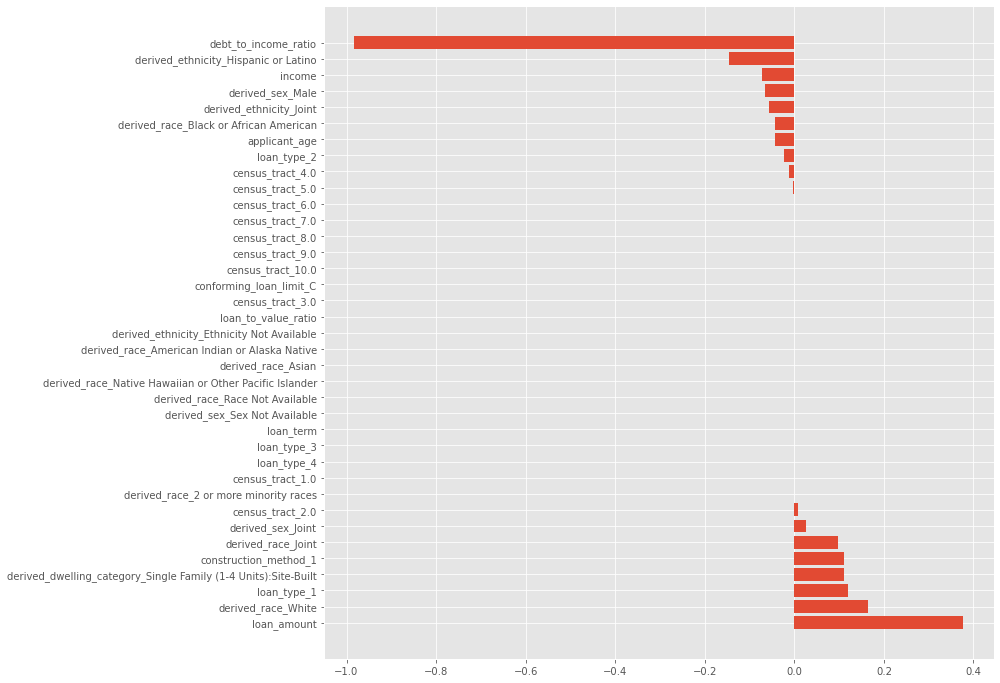

In [436]:
fig, ax = plt.subplots(figsize=(12,12))
ax.barh(features_df.features, width=features_df.coefficients);

In [437]:
# store model performance in dict
boa_dict['Certainty of Prediction'] = f1_score(y_test, sgd_preds)

In [438]:
# Create pickled model
with open('boa_model.pkl', 'wb') as f:
    pickle.dump(fitted, f)

In [439]:
data_tuples = list(zip(features,coefs))
boa_features = pd.DataFrame(data_tuples, columns=['features', 'coefs'])    
%store boa_features

Stored 'boa_features' (DataFrame)


Text(0, 0.5, 'True Positive Rate')

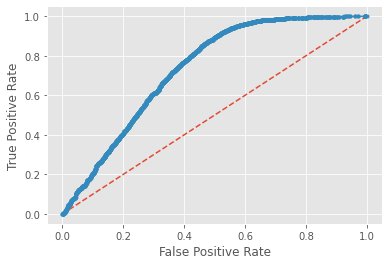

In [440]:
# keep probabilities for the positive outcome only
sgd_probs = sgd_probs[:, 1]

# calculate scores
sgd_auc = roc_auc_score(y_test, sgd_probs)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, sgd_probs)
fig, ax = plt.subplots()
# plot the roc curve for the model
ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
ax.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')




In [441]:
%store boa_dict

Stored 'boa_dict' (dict)


# Threshold Moving

In [614]:
# TP benefit: loan sale
tp_profit = quicken_df['loan_amount'].mean()*0.01

# FP cost: potential to have to buy back the loan and lose street cred with investors - lower rates, etc
## this is rare because underwriters confirm information in the AUS
fp_cost = -tp_profit*1.005

# FN: opportunity cost * market share
fn_cost = -tp_profit*(0.0285)

tn = 0

# Create confusion matrix
cost_benefit_matrix = np.array([[tn, fp_cost],[fn_cost, tp_profit]])
cost_benefit_matrix

array([[    0.        , -3890.73733483],
       [ -110.33434233,  3871.38043267]])

In [615]:
def profit_curve(cost_benefit_matrix, y_prob, y_test):
    """ To calculate list of profits based on supplied cost-benefit
    matrix and predicted probabilities of data points and their true labels.

    Parameters
    ----------
    cost_benefit_matrix    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TN | FP |
                                          -----------
                                          | FN | TP |
                                          -----------
    y_prob : ndarray - 1D, predicted probability for each data point
                                    in labels, in range [0, 1]
    y_test : ndarray - 1D, true label of data points, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))
   
    thresholds = sorted(y_prob, reverse=True)
  
    profits = []
    y_preds = []
    for threshold in thresholds:
#       create boolean array 
        y_pred = y_prob >= threshold
        
#       create a confusion matrix for every threshold to store tn, tp, fn, fp values if that threshold was used
        confusion_mat = confusion_matrix(y_test, y_pred)
    
#     use matrix multiplication to find the overall profit, then divide the num observations to get profit/unit
        profit = np.sum(cost_benefit_matrix*confusion_mat)/n_obs
        profits.append(profit)
        
    return np.array(profits), np.array(thresholds)

In [618]:
profits, thresholds = profit_curve(cost_benefit_matrix, sgd_probs_sub[:,1], y_test_sub)

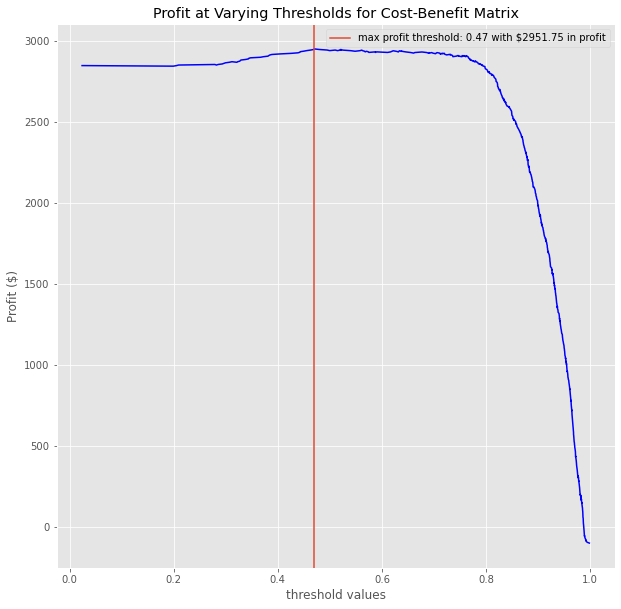

In [619]:
max_profit = np.max(np.array(profits))
max_profit_thresh = thresholds[np.argmax(np.array(profits))]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(thresholds, profits, color='blue')
ax.set_xlabel('threshold values')
ax.set_ylabel('Profit ($)')
ax.axvline(max_profit_thresh, label=f'max profit threshold: {round(max_profit_thresh,2)} with ${round(max_profit, 2)} in profit')
ax.set_title('Profit at Varying Thresholds for Cost-Benefit Matrix')
ax.legend()

In [621]:
# Use threshold from Profit Curve to determine classification
final_preds = []
for i in sgd_probs: 
#     threshold location at highest profit value
    if i >=max_profit_thresh: 
        final_preds.append(1)
    else: 
        final_preds.append(0)
        
# Threshold max
thres_max = pd.DataFrame(data=[accuracy_score(y_test, final_preds), recall_score(y_test, final_preds),
                   precision_score(y_test, final_preds), roc_auc_score(y_test, final_preds), 
                   f1_score(y_test, final_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])
# Threshold 50%
baseline= pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])


baseline['new thresh'] = thres_max[0]

boa_dict['Approval Threshold'] = max_profit_thresh
boa_dict['Certainty of Prediction'] = f1_score(y_test, final_preds)

baseline

,0,new thresh
accuracy,0.895375,0.892279
recall,0.984462,0.993297
precision,0.903954,0.894631
roc_auc_score,0.639491,0.602128
f1 score,0.942492,0.941386


# Bias evaluation

### Start with baseline type I, type II error rates on existing dataset

In [456]:
# Create array of predicted values on entire test set
y_pred_baseline = fitted.predict(X_test)

# Make df of predictions with predicted and true columns to be used for comparison
base_analysis = X_test.copy() 
base_analysis['Pred Approval'] = y_pred_baseline
base_analysis['Actual Approval'] = y_test


# Create DFs with indices of black applicants and white applicants, respectively. Because I am pulling records
# by race, I need to keep the True and Predicted values attached to these rows. No longer doing any prediction. 
black = base_analysis[base_analysis['derived_race_Black or African American'] == 1]
white = base_analysis[base_analysis['derived_race_White'] == 1]
asian = base_analysis[base_analysis['derived_race_Asian'] == 1]
joint_race = base_analysis[base_analysis['derived_race_Joint'] == 1]
race_unavail = base_analysis[base_analysis['derived_race_Race Not Available'] == 1]
male = base_analysis[base_analysis['derived_sex_Male'] == 1]
female = base_analysis[base_analysis['derived_sex_Male'] == 0]
hispanic = base_analysis[base_analysis['derived_ethnicity_Hispanic or Latino'] == 1]
non_hispanic = base_analysis[base_analysis['derived_ethnicity_Hispanic or Latino'] == 0]


# Create confusion matrix to determine baseline type I, II error rates
black_conf = confusion_matrix(black['Actual Approval'], black['Pred Approval'], normalize = 'all')
white_conf = confusion_matrix(white['Actual Approval'], white['Pred Approval'], normalize = 'all')
asian_conf = plus_racial_conf = confusion_matrix(asian['Actual Approval'], asian['Pred Approval'], normalize = 'all')
joint_race_conf = confusion_matrix(joint_race['Actual Approval'], joint_race['Pred Approval'], normalize = 'all')
race_unavail_conf = confusion_matrix(race_unavail['Actual Approval'], race_unavail['Pred Approval'], normalize = 'all')
male_conf = confusion_matrix(male['Actual Approval'], male['Pred Approval'], normalize = 'all')
female_conf = confusion_matrix(female['Actual Approval'], female['Pred Approval'], normalize = 'all')
hisp_conf = confusion_matrix(hispanic['Actual Approval'], hispanic['Pred Approval'], normalize = 'all')
non_hisp_conf = confusion_matrix(non_hispanic['Actual Approval'], non_hispanic['Pred Approval'], normalize = 'all')

#### Compare error rates for black and white applicants after switching those values

In [457]:
X_test_black = X_test.copy()
cond = (X_test_black['derived_race_Black or African American'] ==1) | (X_test_black['derived_race_White'] == 1)
true_race = 'derived_race_Black or African American'
white = 'derived_race_White'
X_test_black.loc[cond, [true_race, white]] = X_test_black.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_black = fitted.predict(X_test_black)

# re-rerun confusion matrix stats
black_swap_analysis = X_test_black.copy()
black_swap_analysis['Pred Approval'] = pred_swap_black
black_swap_analysis['Actual Approval'] = y_test

# white applicants coded as black
white_to_black = black_swap_analysis[black_swap_analysis['derived_race_Black or African American'] == 1]

# black applicants coded as white
black_to_white = black_swap_analysis[black_swap_analysis['derived_race_White'] == 1]

white_to_black_conf = confusion_matrix(white_to_black['Actual Approval'], white_to_black['Pred Approval'], normalize= 'all')
black_to_white_conf = confusion_matrix(black_to_white['Actual Approval'], black_to_white['Pred Approval'], normalize = 'all')

In [458]:
baseline_fn_b = black_conf.ravel()[2]

In [459]:
swapped_fn_b = black_to_white_conf.ravel()[2]

In [460]:
(white_to_black_conf.ravel()[2] - white_conf.ravel()[2]) * 100

0.7334183673469388

In [461]:
print(f'type II error decreased for black applicants by {round(((baseline_fn_b - swapped_fn_b)*100), 2)}% when coded as white')
print(f'type II error increased for white applicants by 0.54% when coded as black')

type II error decreased for black applicants by 1.2% when coded as white
type II error increased for white applicants by 0.54% when coded as black


In [462]:
baseline_fn_b*100

3.429101019462465

In [463]:
swapped_fn_b*100

2.2242817423540315

In [464]:
white_conf.ravel()[2]*100

1.403061224489796

In [465]:
white_to_black_conf.ravel()[2]*100

2.1364795918367347

In [487]:
boa_dict['Black applicant error rate'] = (black_conf.ravel()[2] - black_to_white_conf.ravel()[2])

#### Compare error rates for Asian and white applicants after switching those values


In [467]:
X_test_asian = X_test.copy()
cond = (X_test_asian['derived_race_Asian'] ==1) | (X_test_asian['derived_race_White'] == 1)
true_race = 'derived_race_Asian'
white = 'derived_race_White'
X_test_asian.loc[cond, [true_race, white]] = X_test_asian.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_asian = fitted.predict(X_test_asian)

# re-rerun confusion matrix stats
asian_swap_analysis = X_test_asian.copy()
asian_swap_analysis['Pred Approval'] = pred_swap_asian
asian_swap_analysis['Actual Approval'] = y_test

# white applicants coded as asian
white_to_asian = asian_swap_analysis[asian_swap_analysis['derived_race_Asian'] == 1]

# asian applicants coded as white
asian_to_white = asian_swap_analysis[asian_swap_analysis['derived_race_White'] == 1]

white_to_asian_conf = confusion_matrix(white_to_asian['Actual Approval'], white_to_asian['Pred Approval'], normalize= 'all')
asian_to_white_conf = confusion_matrix(asian_to_white['Actual Approval'], asian_to_white['Pred Approval'], normalize = 'all')

In [468]:
baseline_fn_asian = asian_conf.ravel()[2]
asian_swapped_fn = asian_to_white_conf.ravel()[2]
white_swapped_fn = white_to_asian_conf.ravel()[2]
print(f'type II error changed for asian applicants by {round(((baseline_fn_asian - asian_swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((asian_swapped_fn - baseline_fn_asian)*100), 2)}% when coded as asian')

type II error changed for asian applicants by 0.32% when coded as white
type II error changed for white applicants by -0.32% when coded as asian


In [488]:
boa_dict['Asian applicant error rate'] = (asian_conf.ravel()[2] - asian_to_white_conf.ravel()[2])

#### Compare error rates for biracial or multiracial applicants and white applicants after switching those values


In [470]:
X_test_biracial = X_test.copy()
cond = (X_test_biracial['derived_race_2 or more minority races'] ==1) | (X_test_biracial['derived_race_White'] == 1)
true_race = 'derived_race_2 or more minority races'
white = 'derived_race_White'
X_test_biracial.loc[cond, [true_race, white]] = X_test_biracial.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_biracial = fitted.predict(X_test_biracial)

# re-rerun confusion matrix stats
biracial_swap_analysis = X_test_biracial.copy()
biracial_swap_analysis['Pred Approval'] = pred_swap_biracial
biracial_swap_analysis['Actual Approval'] = y_test

# white applicants coded as biracial
white_to_biracial = biracial_swap_analysis[biracial_swap_analysis['derived_race_2 or more minority races'] == 1]

# biracial applicants coded as white
biracial_to_white = biracial_swap_analysis[biracial_swap_analysis['derived_race_White'] == 1]

white_to_biracial_conf = confusion_matrix(white_to_biracial['Actual Approval'], white_to_biracial['Pred Approval'], normalize= 'all')
biracial_to_white_conf = confusion_matrix(biracial_to_white['Actual Approval'], biracial_to_white['Pred Approval'], normalize = 'all')

In [471]:
baseline_fn = race_unavail_conf.ravel()[2]
biracial_swapped_fn = biracial_to_white_conf.ravel()[2]
white_swapped_fn = white_to_biracial_conf.ravel()[2]
print(f'type II error changed for biracial applicants by {round(((baseline_fn - biracial_swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((biracial_swapped_fn - baseline_fn)*100), 2)}% when coded as biracial')

type II error changed for biracial applicants by 0.66% when coded as white
type II error changed for white applicants by -0.66% when coded as biracial


In [489]:
boa_dict['biracial'] = (race_unavail_conf.ravel()[2] - biracial_to_white_conf.ravel()[2])

#### Compare error rates for applicants that did not specify their race and white applicants after switching those values


In [473]:
X_test_unavail = X_test.copy()
cond = (X_test_unavail['derived_race_Race Not Available'] ==1) | (X_test_unavail['derived_race_White'] == 1)
true_race = 'derived_race_Race Not Available'
white = 'derived_race_White'
X_test_unavail.loc[cond, [true_race, white]] = X_test_unavail.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_unavail = fitted.predict(X_test_unavail)

# re-rerun confusion matrix stats
unavail_swap_analysis = X_test_unavail.copy()
unavail_swap_analysis['Pred Approval'] = pred_swap_unavail
unavail_swap_analysis['Actual Approval'] = y_test

# white applicants coded as unavail
white_to_unavail = unavail_swap_analysis[unavail_swap_analysis['derived_race_Race Not Available'] == 1]

# unavail applicants coded as white
unavail_to_white = unavail_swap_analysis[unavail_swap_analysis['derived_race_White'] == 1]

white_to_unavail_conf = confusion_matrix(white_to_unavail['Actual Approval'], white_to_unavail['Pred Approval'], normalize= 'all')
unavail_to_white_conf = confusion_matrix(unavail_to_white['Actual Approval'], unavail_to_white['Pred Approval'], normalize = 'all')

In [474]:
baseline_fn = joint_race_conf.ravel()[2]
unavail_swapped_fn = unavail_to_white_conf.ravel()[2]
white_swapped_fn = white_to_unavail_conf.ravel()[2]
print(f'type II error changed for applicants who did not specify their race by {round(((baseline_fn - unavail_swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((unavail_swapped_fn - baseline_fn)*100), 2)}% when coded as race unavailable')

type II error changed for applicants who did not specify their race by -0.08% when coded as white
type II error changed for white applicants by 0.08% when coded as race unavailable


In [490]:
boa_dict['unspecified'] = (joint_race_conf.ravel()[2] - unavail_to_white_conf.ravel()[2]) 

#### Compare error rates for male and female applicants


In [476]:
X_test_sex = X_test.copy()
cond = (X_test_sex['derived_sex_Male'] ==1) | (X_test_sex['derived_sex_Male'] == 0)

X_test_sex['derived_sex_Male'] = ~X_test['derived_sex_Male'].values.astype(bool)

pred_swap_sex = fitted.predict(X_test_sex)

# re-rerun confusion matrix stats
sex_swap_analysis = X_test_sex.copy()
sex_swap_analysis['Pred Approval'] = pred_swap_sex
sex_swap_analysis['Actual Approval'] = y_test

# white applicants coded as sex
female_to_male = sex_swap_analysis[sex_swap_analysis['derived_sex_Male'] == 1]

# sex applicants coded as white
male_to_female = sex_swap_analysis[sex_swap_analysis['derived_sex_Male'] == 0]

female_to_male_conf = confusion_matrix(female_to_male['Actual Approval'], female_to_male['Pred Approval'], normalize= 'all')
male_to_female_conf = confusion_matrix(male_to_female['Actual Approval'], male_to_female['Pred Approval'], normalize = 'all')

In [477]:
baseline_fn_m = male_conf.ravel()[2]
m_to_f_fn = male_to_female_conf.ravel()[2]

baseline_fn_f = female_conf.ravel()[2]
f_to_m_fn = female_to_male_conf.ravel()[2]


print(f'type II error changed for male applicants coded as female by {round(((baseline_fn_m - m_to_f_fn)*100), 2)}% ')
print(f'type II error changed for female applicants coded as male applicants by {round(((baseline_fn_f - f_to_m_fn)*100), 2)}% ')

type II error changed for male applicants coded as female by 0.76% 
type II error changed for female applicants coded as male applicants by -0.49% 


In [491]:
boa_dict['Female applicant error rate'] = (female_conf.ravel()[2] - female_to_male_conf.ravel()[2])

#### Compare error rates for hispanic vs non-hispanic

In [479]:
X_test_hispanic = X_test.copy()
cond = (X_test_hispanic['derived_ethnicity_Hispanic or Latino'] ==1) | (X_test_hispanic['derived_ethnicity_Hispanic or Latino'] == 0)

X_test_hispanic['derived_ethnicity_Hispanic or Latino'] = ~X_test['derived_ethnicity_Hispanic or Latino'].values.astype(bool)

pred_swap_hispanic = fitted.predict(X_test_hispanic)

# re-rerun confusion matrix stats
hispanic_swap_analysis = X_test_hispanic.copy()
hispanic_swap_analysis['Pred Approval'] = pred_swap_hispanic
hispanic_swap_analysis['Actual Approval'] = y_test

# hispanic coded as non-hispanic
his_to_non = hispanic_swap_analysis[hispanic_swap_analysis['derived_ethnicity_Hispanic or Latino'] == 1]

# non-hispanic coded as hispanic
non_to_his = hispanic_swap_analysis[hispanic_swap_analysis['derived_ethnicity_Hispanic or Latino'] == 0]

his_to_non_conf = confusion_matrix(his_to_non['Actual Approval'], his_to_non['Pred Approval'], normalize= 'all')
non_to_his_conf = confusion_matrix(non_to_his['Actual Approval'], non_to_his['Pred Approval'], normalize = 'all')

In [480]:
baseline_fn_his = hisp_conf.ravel()[2]
his_to_non_conf_fn = his_to_non_conf.ravel()[2]

baseline_fn_non = non_hisp_conf.ravel()[2]
non_to_his_conf_fn = non_to_his_conf.ravel()[2]


print(f'type II error changed for hispanic applicants coded as non-hispanic by {round(((baseline_fn_his - his_to_non_conf_fn)*100), 2)}% ')
print(f'type II error changed for non-hispanic applicants coded as hispanic applicants by {round(((baseline_fn_non - non_to_his_conf_fn)*100), 2)}% ')

type II error changed for hispanic applicants coded as non-hispanic by 2.63% 
type II error changed for non-hispanic applicants coded as hispanic applicants by -1.53% 


In [492]:
boa_dict['Hispanic applicant error rate'] = (hisp_conf.ravel()[2] - his_to_non_conf.ravel()[2])

In [482]:
hisp_conf.ravel()[2] *100

4.964539007092199

In [483]:
his_to_non_conf.ravel()[2]*100

2.3352713178294575

In [496]:
sgd_probs = sgd_fitted2.predict_proba(X_test)[:,1]

In [622]:
%store boa_dict
with open('boa_dict.pkl', 'wb') as f: 
    pickle.dump(boa_dict,f)
    
with open('boa_preds.pkl', 'wb') as f:
    pickle.dump(sgd_probs, f)

with open('boa_df.pkl', 'wb') as f:
    boa_df = pickle.dump(quicken_df, f)

Stored 'boa_dict' (dict)


# Get feature importance

In [242]:
feat_import = fitted.best_estimator_.named_steps['classifier'].feature_importances_
feature_importance = pd.Series(feat_import, index= X_train_sub.columns)
feature_importance.sort_values(inplace = True)
feature_importance.plot(kind = 'barh', figsize=(20,20))

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

In [105]:
X.head()

,loan_amount,loan_to_value_ratio,loan_term,negative_amortization,balloon_payment,income,debt_to_income_ratio,applicant_age,census_tract_1.0,census_tract_2.0,census_tract_3.0,census_tract_4.0,census_tract_5.0,census_tract_6.0,census_tract_7.0,census_tract_8.0,census_tract_9.0,census_tract_10.0,conforming_loan_limit_C,derived_dwelling_category_Single Family (1-4 Units):Site-Built,derived_ethnicity_Ethnicity Not Available,derived_ethnicity_Free Form Text Only,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Free Form Text Only,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,loan_type_1,loan_type_2,loan_type_3,construction_method_1,applicant_ethnicity_observed_1.0,applicant_race_observed_1.0,aus-1_2,aus-1_3,aus-1_5,aus-1_6
16,55000.0,97.00,360.0,2,2,17.0,39.0,6.0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
28,35000.0,24.53,360.0,2,2,23.0,41.0,5.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
35,615000.0,80.00,360.0,2,2,224.0,33.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0
39,265000.0,96.50,360.0,2,2,125.0,36.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0
42,115000.0,80.00,360.0,2,2,30.0,38.0,2.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [107]:
quicken_df.columns

Index(['census_tract', 'conforming_loan_limit', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'loan_type', 'loan_amount', 'loan_to_value_ratio', 'loan_term',
       'negative_amortization', 'balloon_payment', 'construction_method',
       'income', 'debt_to_income_ratio', 'applicant_ethnicity_observed',
       'applicant_race_observed', 'applicant_age', 'aus-1'],
      dtype='object')

In [129]:
example = X_test.iloc[200].values.reshape(1, -1)
example.shape

(1, 46)

In [131]:
fitted.predict_proba(example)

array([[0.04886914, 0.95113086]])

In [174]:
from joblib import dump, load
dump(fitted, 'boa_pickle.joblib') 

['boa_pickle.joblib']

In [176]:
fitted = load('boa_pickle.joblib') 

In [177]:
fitted.predict(example)

AttributeError: 'str' object has no attribute 'predict'

# Determine Threshold

In [159]:
cost_benefit_matrix = np.array([[145, -50],[-145, 0]])
cost_benefit_matrix

array([[ 145,  -50],
       [-145,    0]])

In [116]:
def profit_curve(cost_benefit_matrix, y_prob, y_test):
    """ To calculate list of profits based on supplied cost-benefit
    matrix and predicted probabilities of data points and their true labels.

    Parameters
    ----------
    cost_benefit_matrix    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    y_prob : ndarray - 1D, predicted probability for each data point
                                    in labels, in range [0, 1]
    y_test : ndarray - 1D, true label of data points, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))

  
    thresholds =  sorted(y_prob[:,1], reverse=True)
    profits = []
    y_preds = []
    for threshold in thresholds:

        y_pred = y_prob[:,1] >= threshold
        confusion_mat = confusion_matrix(y_test, y_pred)
        profit = np.sum(cost_benefit_matrix*confusion_mat)/n_obs
        profits.append(profit)
    return np.array(profits), np.array(thresholds)

In [160]:
profits, thresholds = profit_curve(cost_benefit_matrix, rf_probs_u, y_test_u)

In [161]:
prof = np.round(profits, 3)
thresh = np.round(thresholds, 3)

Text(0.5, 1.0, 'Profit at Varying Thresholds for Cost-Benefit Matrix')

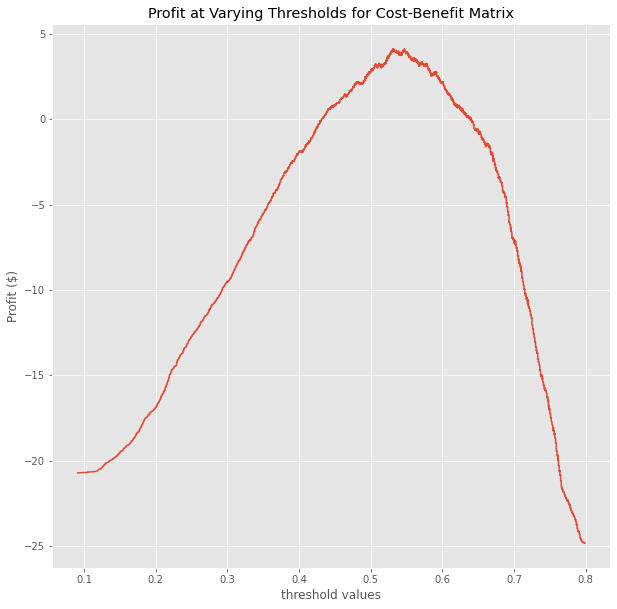

In [162]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(thresh, prof)
ax.set_xlabel('threshold values')
ax.set_ylabel('Profit ($)')
ax.set_title('Profit at Varying Thresholds for Cost-Benefit Matrix')

In [145]:
rf_probs = rf_fitted2.predict_proba(X_test_sub)

In [170]:
# Use threshold from Profit Curve to determine classification
final_preds = []
for i in rf_probs_u[:,1]: 
    if i >=0.55: 
        final_preds.append(1)
    else: 
        final_preds.append(0)
        

In [171]:
accuracy_score(y_test_u, final_preds)

0.6805836336468313

In [142]:
accuracy_score?

In [183]:
clf = LogisticRegressionCV()
clf.fit(X_train_sub, y_train_sub)
THRESHOLD = 0.55
preds = np.where(clf.predict_proba(X_test_sub)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test_sub, preds), recall_score(y_test_sub, preds),
                   precision_score(y_test_sub, preds), roc_auc_score(y_test_sub, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.829513
recall,1.000000
precision,0.829513
roc_auc_score,0.500000


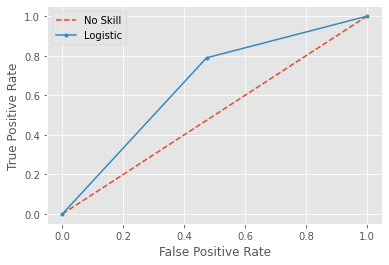

In [173]:
rf_probs_u = rf_fitted2.predict_proba(X_test_u)

# keep probabilities for the positive outcome only
rf_probs_u = rf_probs_u[:, 1]

# calculate scores
rf_auc = roc_auc_score(y_test_u, final_preds)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, final_preds)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

## Tuning Logistic Regression

In [185]:
lr_pipe_u = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=5000))])
lr_grid_params_u = {'classifier__penalty' : ['l2', 'elasticnet'], 'classifier__C' : np.logspace(-4, 4, 20),
                        'classifier__solver' : ['liblinear', 'saga']}
lr_grid_u = GridSearchCV(lr_pipe_u, lr_grid_params_u, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
lr_fitted_u = lr_grid_u.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')



/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

KeyboardInterrupt: 

# Stochastic Gradient Descent Classifier - ran almost instantaneously
* Parameter Tuning:
    * will use either log or modified-huber for the loss function as these support probabilistic estimates


In [221]:
# Baseline Model
# compare full dataset vs RUS
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted = sgd_pipe.fit(X_train, y_train)
sgd_preds = fitted.predict(X_test)

In [223]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.835740
recall,0.999182
precision,0.835608
roc_auc_score,0.512294
f1 score,0.910104


In [231]:
# Parameter Tuning

sgd_pipe2 = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_grid_params2 = {'classifier__alpha': 10.0**-np.arange(1,7), 
                   'classifier__loss': ['log'], 
                  'classifier__penalty': ['l2', 'l1', 'elasticnet']}
sgd_grid2 = GridSearchCV(sgd_pipe2, sgd_grid_params2, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2 = sgd_grid2.fit(X_train, y_train)
sgd_preds2 = sgd_fitted2.predict(X_test)



In [232]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds2), recall_score(y_test, sgd_preds2),
                   precision_score(y_test, sgd_preds2), roc_auc_score(y_test, sgd_preds2), 
                   f1_score(y_test, sgd_preds2)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.833303
recall,0.998622
precision,0.833879
roc_auc_score,0.506143
f1 score,0.908845


In [233]:
# Baseline Model: RUS
sgd_pipe_u = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted_u = sgd_pipe.fit(X_train_u, y_train_u)
sgd_preds_u = fitted.predict(X_test_u)

In [234]:
pd.DataFrame(data=[accuracy_score(y_test_u, sgd_preds_u), recall_score(y_test_u, sgd_preds_u),
                   precision_score(y_test_u, sgd_preds_u), roc_auc_score(y_test_u, sgd_preds_u), 
                   f1_score(y_test_u, sgd_preds_u)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.626000
recall,0.789134
precision,0.648495
roc_auc_score,0.592276
f1 score,0.711936


In [235]:
# Parameter Tuning: RUS sample

sgd_pipe2_u = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_grid_params2_u = {'classifier__alpha': 10.0**-np.arange(1,7), 
                   'classifier__loss': ['log'], 
                  'classifier__penalty': ['l2', 'l1', 'elasticnet']}
sgd_grid2_u = GridSearchCV(sgd_pipe2_u, sgd_grid_params2_u, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2_u = sgd_grid2.fit(X_train_u, y_train_u)
sgd_preds2_u = sgd_fitted2.predict(X_test_u)


In [236]:
pd.DataFrame(data=[accuracy_score(y_test_u, sgd_preds_u), recall_score(y_test_u, sgd_preds_u),
                   precision_score(y_test_u, sgd_preds_u), roc_auc_score(y_test_u, sgd_preds_u), 
                   f1_score(y_test_u, sgd_preds_u)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.626000
recall,0.789134
precision,0.648495
roc_auc_score,0.592276
f1 score,0.711936


In [237]:
sgd_probs = sgd_fitted2.predict_proba(X_test)

# Predictions with threshold from Profit Curve
final_preds_sgd = []
for i in sgd_probs[:,1]: 
    if i >=0.55: 
        final_preds_sgd.append(1)
    else: 
        final_preds_sgd.append(0)
        
# keep probabilities for the positive outcome only
sgd_probs = sgd_probs[:, 1]

# calculate scores
sgd_auc = roc_auc_score(y_test, final_preds_sgd)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, final_preds_sgd)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [11377, 27907]

In [212]:
quicken_df.columns

Index(['census_tract', 'conforming_loan_limit', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'loan_type', 'loan_amount', 'loan_to_value_ratio', 'loan_term',
       'property_value', 'construction_method', 'occupancy_type',
       'total_units', 'income', 'debt_to_income_ratio',
       'applicant_credit_score_type', 'applicant_ethnicity_observed',
       'applicant_race_observed', 'applicant_age', 'aus-1'],
      dtype='object')

In [213]:
quicken_df['derived_race'].value_counts()

White                                        81852
Race Not Available                           40618
Black or African American                     8189
Asian                                         5991
Joint                                         1828
American Indian or Alaska Native               651
Native Hawaiian or Other Pacific Islander      236
2 or more minority races                       168
Name: derived_race, dtype: int64

In [215]:
600/81852*100

0.7330303474563847

In [243]:
X_test_swap = X_test.copy()

In [244]:
cond = X_test_swap['derived_race_Black or African American'] ==1 or 
true_race = 'derived_race_Black or African American'
white = 'derived_race_White'
X_test_swap.loc[cond, [true_race, white]] = \
                        X_test_swap.loc[cond, [white, true_race]].values

In [271]:
X_test_swap[X_test_swap.index==303994]

,loan_amount,loan_to_value_ratio,loan_term,property_value,total_units,income,debt_to_income_ratio,applicant_age,census_tract_1.0,census_tract_2.0,census_tract_3.0,census_tract_4.0,census_tract_5.0,census_tract_6.0,census_tract_7.0,census_tract_8.0,census_tract_9.0,census_tract_10.0,conforming_loan_limit_C,derived_dwelling_category_Single Family (1-4 Units):Site-Built,derived_ethnicity_Ethnicity Not Available,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,loan_type_1,loan_type_2,loan_type_3,loan_type_4,construction_method_1,occupancy_type_1,occupancy_type_3,applicant_credit_score_type_1.0,applicant_credit_score_type_2.0,applicant_credit_score_type_3.0,applicant_ethnicity_observed_1.0,applicant_race_observed_1.0,aus-1_1,aus-1_2,aus-1_4,aus-1_6
303994,115000.0,97.0,360,115000.0,1,48.0,38.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0.0,0,0,0,1.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0


In [256]:
X_test.loc[cond].head()

,loan_amount,loan_to_value_ratio,loan_term,property_value,total_units,income,debt_to_income_ratio,applicant_age,census_tract_1.0,census_tract_2.0,census_tract_3.0,census_tract_4.0,census_tract_5.0,census_tract_6.0,census_tract_7.0,census_tract_8.0,census_tract_9.0,census_tract_10.0,conforming_loan_limit_C,derived_dwelling_category_Single Family (1-4 Units):Site-Built,derived_ethnicity_Ethnicity Not Available,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,loan_type_1,loan_type_2,loan_type_3,loan_type_4,construction_method_1,occupancy_type_1,occupancy_type_3,applicant_credit_score_type_1.0,applicant_credit_score_type_2.0,applicant_credit_score_type_3.0,applicant_ethnicity_observed_1.0,applicant_race_observed_1.0,aus-1_1,aus-1_2,aus-1_4,aus-1_6
350626,255000.0,96.50,360,255000.0,1,93.0,55.0,1.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
303994,115000.0,97.00,360,115000.0,1,48.0,38.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
348525,225000.0,96.95,360,235000.0,1,55.0,33.0,6.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
9096,105000.0,97.00,360,105000.0,1,42.0,25.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0
324658,315000.0,80.00,360,395000.0,1,85.0,42.0,4.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0


In [270]:
X_test[X_test.index == 303994]

,loan_amount,loan_to_value_ratio,loan_term,property_value,total_units,income,debt_to_income_ratio,applicant_age,census_tract_1.0,census_tract_2.0,census_tract_3.0,census_tract_4.0,census_tract_5.0,census_tract_6.0,census_tract_7.0,census_tract_8.0,census_tract_9.0,census_tract_10.0,conforming_loan_limit_C,derived_dwelling_category_Single Family (1-4 Units):Site-Built,derived_ethnicity_Ethnicity Not Available,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,loan_type_1,loan_type_2,loan_type_3,loan_type_4,construction_method_1,occupancy_type_1,occupancy_type_3,applicant_credit_score_type_1.0,applicant_credit_score_type_2.0,applicant_credit_score_type_3.0,applicant_ethnicity_observed_1.0,applicant_race_observed_1.0,aus-1_1,aus-1_2,aus-1_4,aus-1_6
303994,115000.0,97.0,360,115000.0,1,48.0,38.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0


In [318]:
X_test_black = X_test.copy()
cond = (X_test_black['derived_race_Black or African American'] ==1) | (X_test_black['derived_race_White'] == 1)
true_race = 'derived_race_Black or African American'
white = 'derived_race_White'
X_test_black.loc[cond, [true_race, white]] = X_test_black.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_black = sgd_fitted.predict(X_test_black)

# re-rerun confusion matrix stats
black_swap_analysis = X_test_black.copy()
black_swap_analysis['Pred Approval'] = pred_swap_black
black_swap_analysis['Actual Approval'] = y_test
black = black_swap_analysis[black_swap_analysis['derived_race_Black or African American'] == 1]
white = black_swap_analysis[black_swap_analysis['derived_race_White'] == 1]
black_conf = confusion_matrix(black['Actual Approval'], black['Pred Approval'], normalize= 'all')
white_conf = confusion_matrix(white['Actual Approval'], white['Pred Approval'], normalize = 'all')

In [319]:
black_conf

array([[0.00257685, 0.15062274],
       [0.        , 0.84680042]])

In [320]:
white_conf

array([[0.00672372, 0.24022005],
       [0.        , 0.75305623]])

In [323]:
# Create array of predicted values on entire test set
y_pred_baseline = sgd_fitted.predict(X_test)

# Make df of predictions with predicted and true columns to be used for comparison
analysis = X_test.copy() 
analysis['Pred Approval'] = y_pred_baseline
analysis['Actual Approval'] = y_test


# Create DFs with indices of black applicants and white applicants, respectively. Because I am pulling records
# by race, I need to keep the True and Predicted values attached to these rows. No longer doing any prediction. 
black = analysis[analysis['derived_race_Black or African American'] == 1]
white = analysis[analysis['derived_race_White'] == 1]
asian = analysis[analysis['derived_race_Asian'] == 1]
joint_race = analysis[analysis['derived_race_Joint'] == 1]
race_unavail = analysis[analysis['derived_race_Race Not Available'] == 1]

# Create confusion matrix to determine baseline type I, II error rates
black_conf = confusion_matrix(black['Actual Approval'], black['Pred Approval'], normalize = 'all')
white_conf = confusion_matrix(white['Actual Approval'], white['Pred Approval'], normalize = 'all')
asian_conf = plus_racial_conf = confusion_matrix(asian['Actual Approval'], asian['Pred Approval'], normalize = 'all')
joint_race_conf = confusion_matrix(joint_race['Actual Approval'], joint_race['Pred Approval'], normalize = 'all')
race_unavail_conf = confusion_matrix(race_unavail['Actual Approval'], race_unavail['Pred Approval'], normalize = 'all')



In [324]:
black_conf

array([[0.00672372, 0.24022005],
       [0.        , 0.75305623]])

In [325]:
white_conf

array([[0.00257685, 0.15062274],
       [0.        , 0.84680042]])

In [455]:
quicken_df['loan_type'].value_counts()

1    52411
2     3658
3      463
4        1
Name: loan_type, dtype: int64